In [6]:
from pincell_moment_utils import postprocessing as pp
import time

# First extract the surface fluxes from the tallies, then use them to compute the moments of the expansion 
mesh_tally = pp.SurfaceMeshTally('../data/source_statepoint.100.h5')
coefficients = pp.compute_moments(mesh_tally, 7, 5)

expansion = pp.SurfaceExpansion(coefficients, mesh_tally.energy_filters)

start = time.time()
samples = expansion.generate_samples(100000, num_cores=8, method='ensemble', burn_in=1000, use_log_energy=True, progress=True)
stop = time.time()
print(stop - start)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/mlouis9/miniconda3/envs/openmc-env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 781/781 [00:48<00:00, 16.22it/s]


438.92157435417175


## Verify the Spatial-Angle Distribution of Generated Samples
First we plot the generated sample points and compare them with the corresponding plots of the flux generated in previous tests.

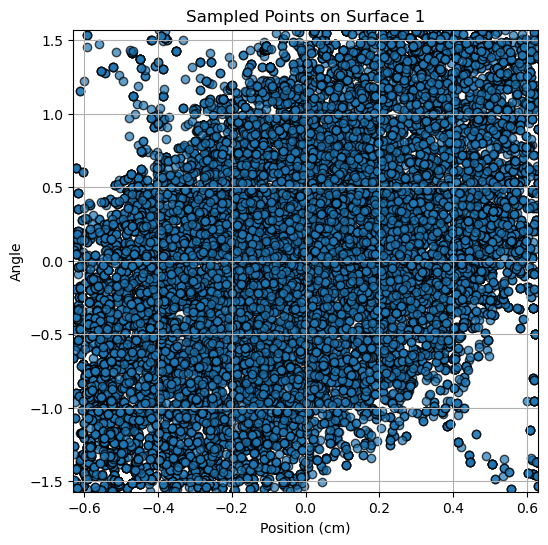

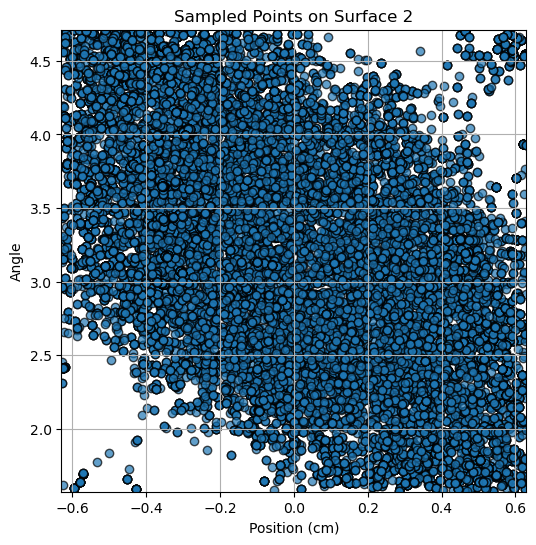

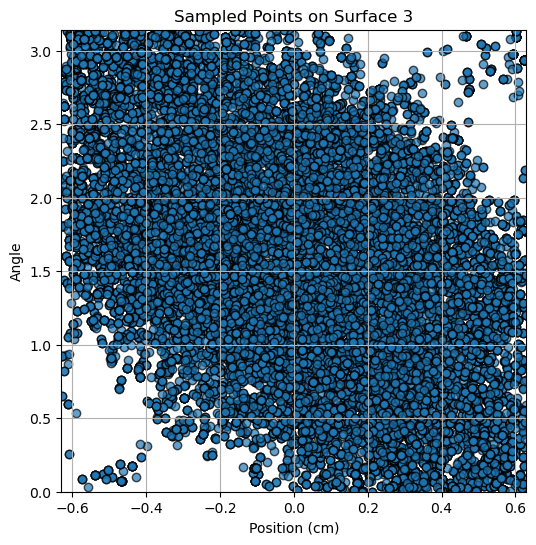

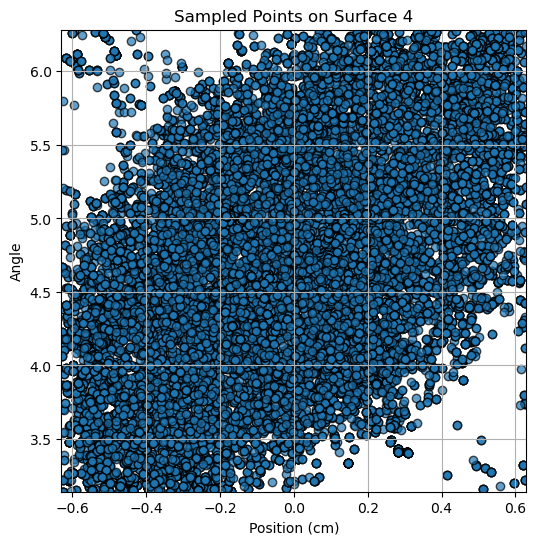

In [7]:
import matplotlib.pyplot as plt
from pincell_moment_utils import config
from pincell_moment_utils.plotting import reconstruction_comparison

for surface in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[surface][:,0], samples[surface][:,1], marker='o', alpha=0.7, edgecolors='k')
    plt.xlabel('Position (cm)')
    plt.ylabel('Angle')
    plt.xlim(config.SPATIAL_BOUNDS[surface][0], config.SPATIAL_BOUNDS[surface][1])
    plt.ylim(config.ANGULAR_BOUNDS[surface][0], config.ANGULAR_BOUNDS[surface][1])
    plt.title(f'Sampled Points on Surface {surface +1}')
    plt.grid()

Compare with the corresponding plots of the flux through the most probable energy slice

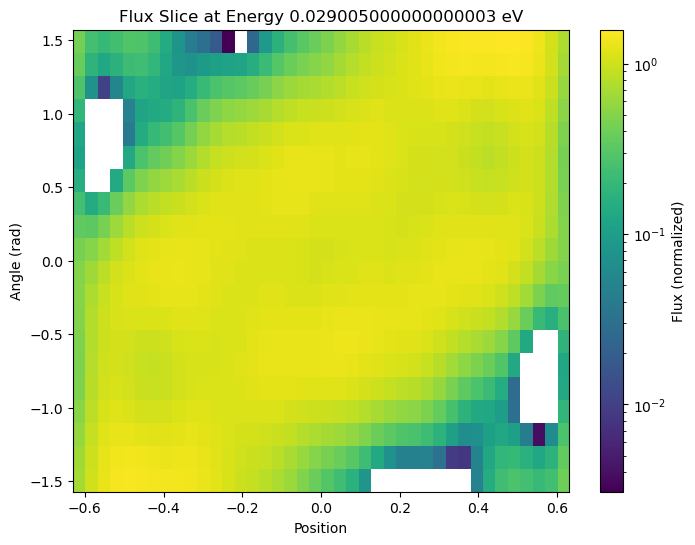

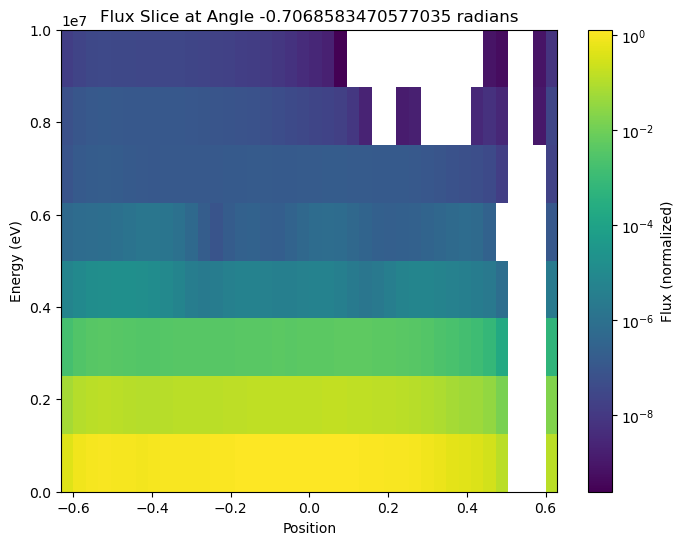

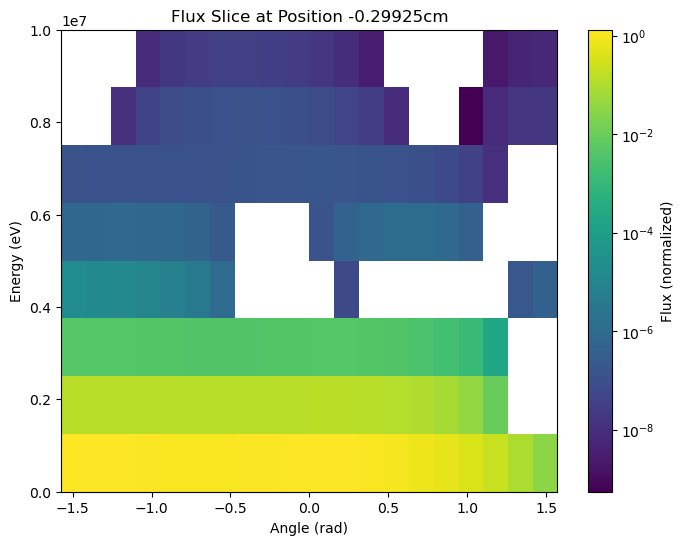

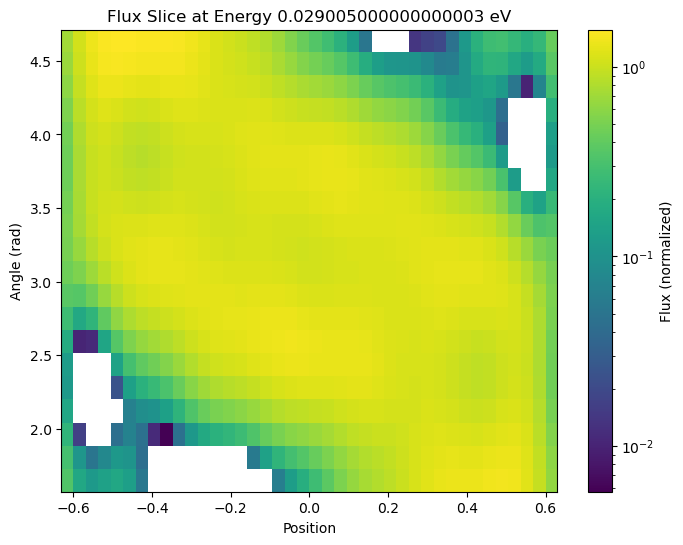

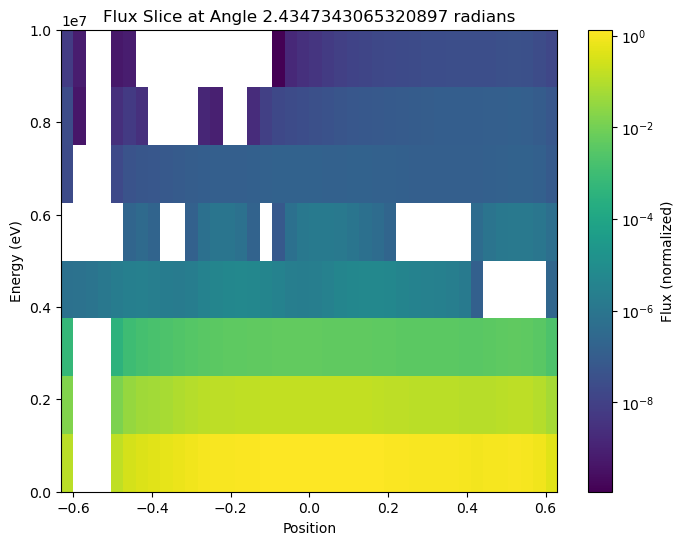

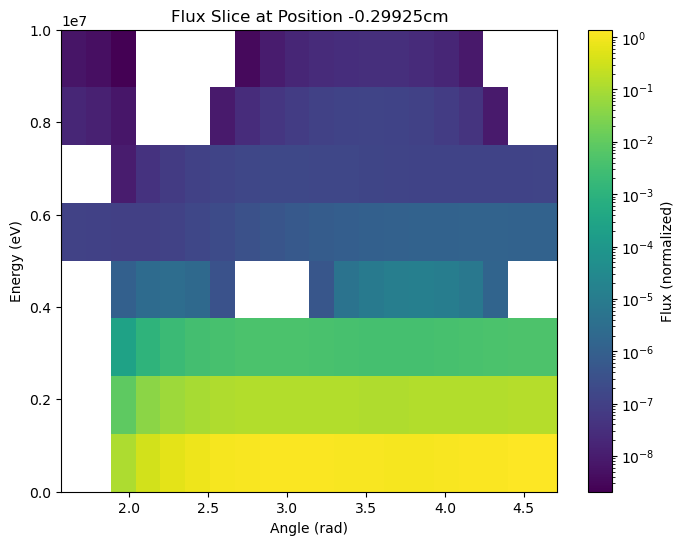

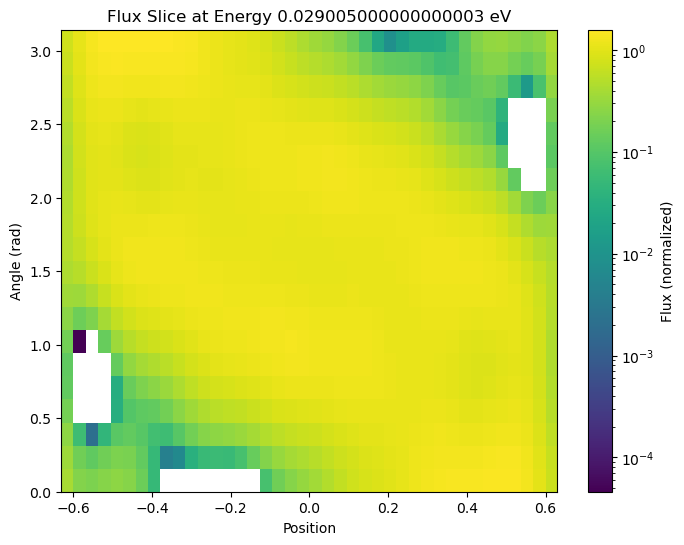

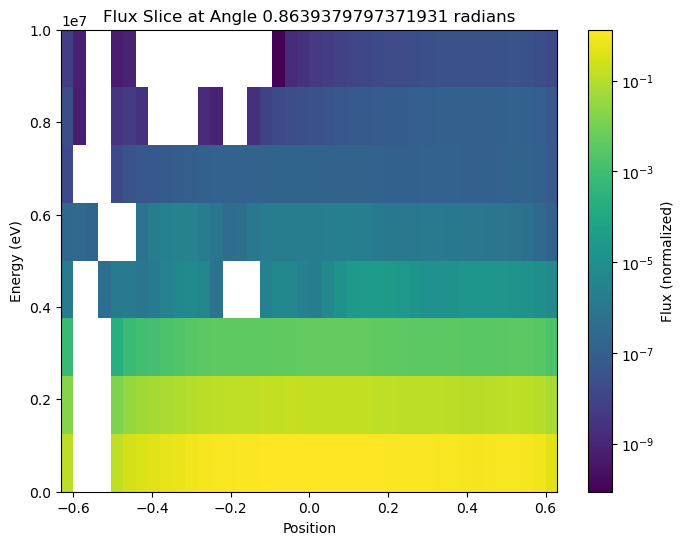

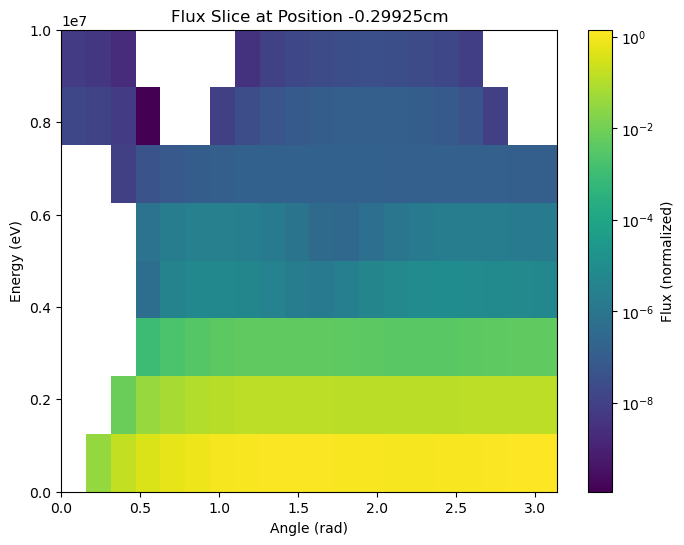

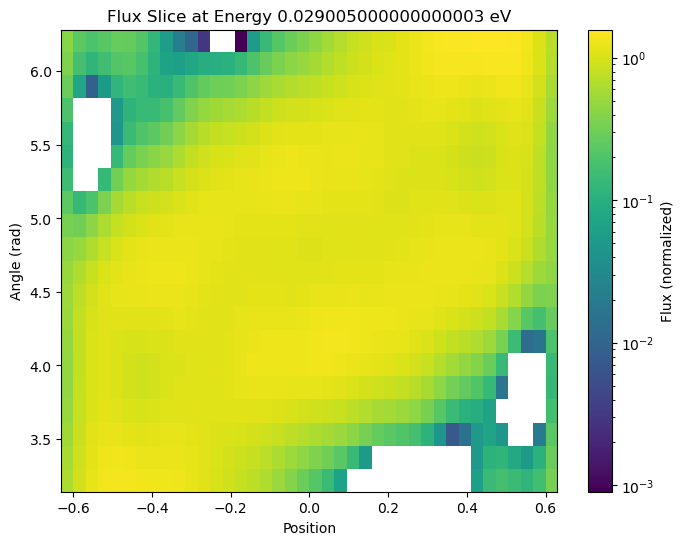

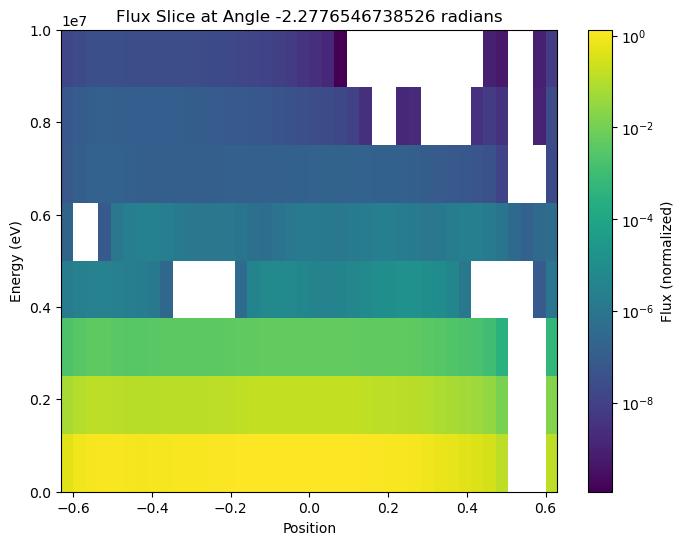

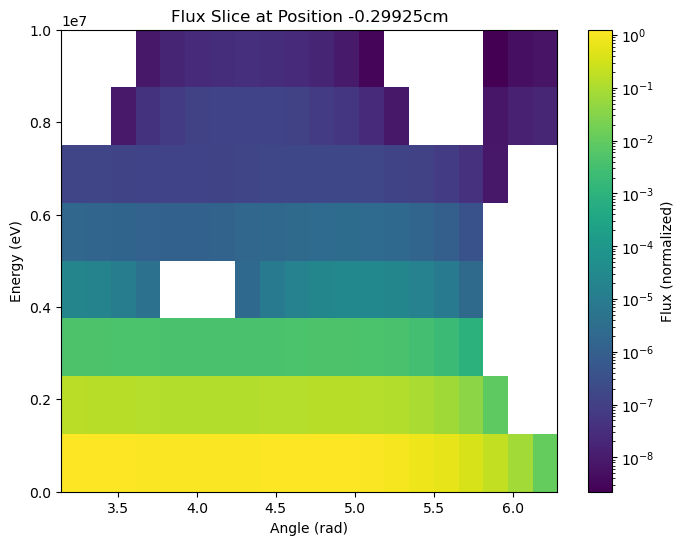

In [3]:
for surface in range(4):
    reconstruction_comparison(expansion, mesh_tally, 10, 5, 0, surface, option='expansion')

Make sure the spatial points are all within the proper bounds

In [4]:
import numpy as np

for surface in range(4):
    print(f"Max  {np.max(samples[surface][:,0])}, pitch/2={config.PITCH/2}")
    print(f"Min {np.min(samples[surface][:,0])}, -pitch/2={-config.PITCH/2}")

Max  0.6255145980481109, pitch/2=0.63
Min -0.6282515927290329, -pitch/2=-0.63
Max  0.6250826440132208, pitch/2=0.63
Min -0.622329570333925, -pitch/2=-0.63
Max  0.6297476311520973, pitch/2=0.63
Min -0.6276440900362221, -pitch/2=-0.63
Max  0.6267411050886842, pitch/2=0.63
Min -0.6295534424311484, -pitch/2=-0.63


## Benchmark the Energy Distribution of the points
Lastly, it's prudent to plot the energy distribution of the points

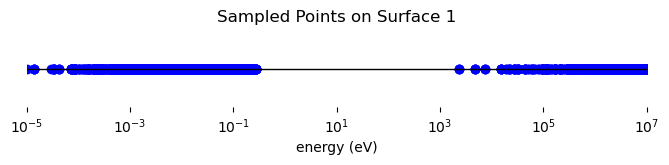

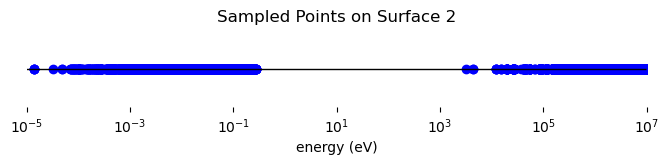

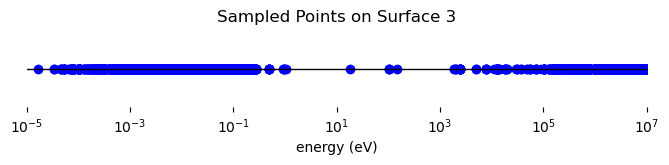

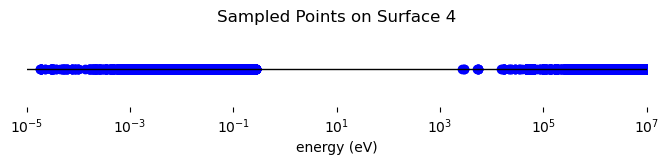

In [8]:
energy_bounds = expansion.energy_bounds

for surface in range(4):
    plt.figure(figsize=(8, 1))  # Make it a horizontal strip

    # Plot the points on a line
    plt.scatter(samples[surface][:,2], np.zeros_like(samples[surface][:,2]), marker='o', color='b')

    # Draw the line
    plt.hlines(0, min(samples[surface][:,2]) - 0.1, max(samples[surface][:,2]) + 0.1, colors='black', linewidth=1)

    # Remove y-axis
    plt.yticks([])
    plt.box(False)  # Remove the surrounding box
    plt.xlabel('energy (eV)')
    plt.xlim(energy_bounds[surface][0], energy_bounds[surface][1])
    plt.xscale('log')
    plt.title(f'Sampled Points on Surface {surface + 1}')

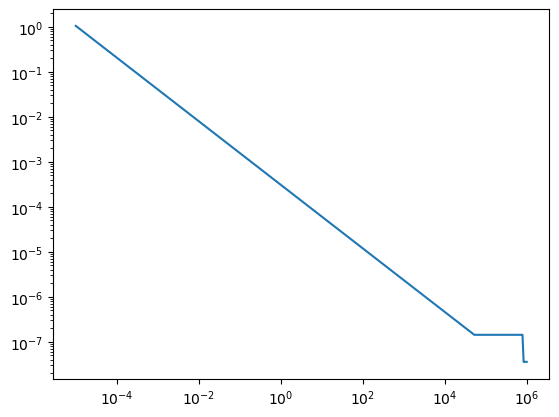

In [43]:
plt.plot(np.linspace(1E-05, 1E+06, 20), [ expansion.flux_functions[0](0,0, E) for E in np.linspace(1E-05, 1E+06, 20)])
plt.yscale('log')
plt.xscale('log')

Calculate the ratio of "high energy" source particles to "low energy" source particles

In [13]:
print(np.size(np.where(samples[0][:, 2] < 1))/np.size(np.where(samples[0][:, 2] > 1)))

9.663679043960734


Though there still seems to be many more high energy samples that we'd expect, this could very well be consistent with the distribution since, although the density at higher energies is much smaller, the energy range is much larger. In any case, this can be controlled by biasing the initial samples used for the MCMC sampling algorithm